[GloVe](https://github.com/stanfordnlp/GloVe) - одна из популярных альтернатив моделям word2vec, предложенная лабораторией компьютерной лингвистики Стенфордского университета.

Она сочетает в себе преимущества LSA и его современных реализаций и локальных методов (word2vec и его варианты, например, negative sampling). Идея в том, чтобы одновременно переложить локальные методы на матрицы совместной встречаемости, но при этом избежать сложностей, связанных с неравномерностью.

GloVe, как и LSA, пытается приблизить матрицу встречаемости слов (вероятности того, что слово j встретится в контексте слова i), но, в отличие от вариантов LSA, приближает не сами вероятности, а отношения этих вероятностей.
Такой подход легко интерпретируется: если слово x встречается в контексте слова k чаще, чем в контексте слова j, то x и k связаны друг с другом сильнее.

В статье ["GloVe: Global Vectors for Word Representations"](http://www.aclweb.org/anthology/D14-1162) авторы утверждают, что на многих задачах обработки текстов метод работает даже лучше, чем word2vec.

Правда, [есть мнение](https://plus.google.com/114479713299850783539/posts/BYvhAbgG8T2), что эксперименты, приведённые в статье, не полностью корректны, и на самом деле разница между двумя методами не так существенна.

На [сайте проекта](https://nlp.stanford.edu/projects/glove/) можно скачать модели, преобученные на данных Википедии или Твиттера, и использовать их для своих целей, но попробуем сами обучить векторные представления на небольшом корпусе и посмотреть, что получится.

In [3]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from itertools import chain
from glob import glob
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE

## Подготовка корпуса

Для тренировки векторов на собственном корпусе он должен выглядеть как один текстовый файл, содержащий исключительно слова, разделенные пробелами.

Попробуем обучить векторы на трилогии Толкиена "Властелин колец" и книге "Хоббит, или Туда и обратно".

Объединяем текстовые файлы в один файл:

In [2]:
filenames = ['L1.txt', 'L2.txt', 'L3.txt','Hobbit.txt']
with open('lord_of_the_rings.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

Делаем простую предобработку текста (удаляем лишние символы, приводим к нижнему регистру):

In [ ]:
f = open('lord_of_the_rings.txt', 'r')
text = f.read()
lines = [text.lower() for line in 'lord_of_the_rings.txt']
lines = [re.sub(r'\W',' ',line) for line in lines]
with open('lord_of_the_rings.txt', 'w') as out:
    out.writelines(lines)

Запускаем [скрипт](https://github.com/stanfordnlp/GloVe/blob/master/demo.sh). Предварительно нужно удалить часть между make и CORPUS, вместо text8 вписываем название своего файла. 

## Получившиеся векторы и схожесть слов

Получились вот такие векторы:

In [205]:
df = pd.read_table("vectors.txt", encoding='iso8859_15', delimiter=" ", header=None, index_col=0)
df.loc[["man", "woman","king","hobbit"]]

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
man,0.253797,-0.666057,0.388722,-0.175206,0.648564,-0.149181,0.020618,0.329535,-0.220808,-0.681564,...,0.025813,0.642394,0.137454,-0.084969,-1.393941,-0.007673,0.466769,0.881422,-0.309771,-0.179292
woman,-0.723761,-0.517782,-0.569553,-0.204953,0.920549,0.127949,-0.370071,0.459164,0.183481,0.051037,...,-0.135750,0.297686,1.155730,-0.417187,0.349185,0.397016,-0.531810,0.846358,0.180636,-0.452571
king,-0.372379,-0.362609,0.849181,1.023329,0.287253,0.401149,0.878640,0.348451,0.105714,-0.555859,...,-0.074310,0.017748,-0.249820,-0.465206,-2.033368,-0.627899,0.659800,0.992717,0.335019,0.838949
hobbit,-0.370915,-1.280207,0.455426,0.387526,0.265136,-1.694200,-1.067922,-0.060875,-0.335427,0.745662,...,-0.044762,0.265223,0.090084,0.202508,-0.645625,-0.420841,0.577888,0.289225,0.715033,0.293419


In [206]:
df = df.div(np.linalg.norm(df, axis=1), axis=0)
print("'man' L2-norm:", np.linalg.norm(df.loc["man"]))

'man' L2-norm: 1.0


Посмотрим, наскольк адекватными получились результаты и насколько хорошо векторы, обученные на таком небольшом корпусе, решают задачу семантической схожести.

In [207]:
def similar_words(df, word, n=10, exceptions=[]):
    """Вернуть n ближайших слов"""
    return df.loc[~df.index.isin(exceptions)].dot(word).sort_values(ascending=False).head(n)

def find_analogies(analogies, n=1):
    """Вернуть n ближайших слов по аналогии man - woman = WORD - queen"""
    word1, word2, word3 = analogies.split()[::2]
    vec = df.loc[word1] - df.loc[word2] + df.loc[word3]
   
    topn =  similar_words(
        df, vec, 
        exceptions=[word1, word2, word3],
        n=n+3
    )
    analogy = "%s is to %s AS %s is to %s" % (word2, word3, word1, "?")
    top_res = ["%s = %s (%.2f)" % (analogy, topn.index[i], topn[i]) for i in range(n)]
    print("\n".join(top_res))

### Близкие понятия

Вектор "Фродо" неплохо отражает реальность. Рядом оказались имена других хоббитов и обращения (Mr.Frodo, Master):

In [208]:
similar_words(df, df.loc["frodo"])

0
frodo      1.000000
sam        0.836367
pippin     0.673213
mr         0.664386
master     0.637003
said       0.624658
did        0.621102
bilbo      0.612558
thought    0.602697
me         0.602315
dtype: float64

Схожие с "драконом" слова тоже похожи на правду (dragon slain, Smaug, gold):

In [209]:
similar_words(df, df.loc["dragon"])

0
dragon       1.000000
smaug        0.593494
slain        0.492666
free         0.482210
chief        0.476859
gold         0.475978
orders       0.460570
33           0.451178
destroyed    0.438847
twice        0.437289
dtype: float64

Вектор для "mountains" тоже отражает реалии книги:

In [210]:
similar_words(df, df.loc["mountains"])

0
mountains    1.000000
mountain     0.719102
misty        0.703873
far          0.686530
west         0.656400
forest       0.619724
south        0.613328
beyond       0.612000
shadow       0.605806
hills        0.605427
dtype: float64

### Отношения между персонажами

Теперь посмотрим на аналогии.

Стандартный пример с "he - she = his - her" неплохо работает.

In [211]:
find_analogies("his - he + she", n=3)

he is to she AS his is to ? = her (0.97)
he is to she AS his is to ? = Ã©owyn (0.78)
he is to she AS his is to ? = fair (0.71)


Попробуем с помощью получившихся векторов узнать что-нибудь о союзниках и противниках разных персонажей.

Например, Гендальф оказался для Арагорна таким же другом, как Сэм для Фродо.

In [212]:
find_analogies("gandalf - sam + frodo", n=3)

sam is to frodo AS gandalf is to ? = aragorn (0.93)
sam is to frodo AS gandalf is to ? = said (0.74)
sam is to frodo AS gandalf is to ? = me (0.74)


Для Леголаса это Гимли и Арагорн - тоже сходится с сюжетом.

In [213]:
find_analogies("legolas - sam + frodo", n=3)

sam is to frodo AS legolas is to ? = gimli (0.87)
sam is to frodo AS legolas is to ? = aragorn (0.85)
sam is to frodo AS legolas is to ? = Ã©omer (0.79)


Попробуем что-нибудь со знаком "минус":

In [214]:
find_analogies("frodo - gandalf + sauron", n=3)

gandalf is to sauron AS frodo is to ? = horror (0.69)
gandalf is to sauron AS frodo is to ? = morgoth (0.66)
gandalf is to sauron AS frodo is to ? = hiding (0.65)


Для Фродо противниками оказались horror, hiding и Morgoth (персонаж, олицетворяющий сторону зла в мире Толкиена) - неплохой результат.

### Определение рас персонажей

Если Фродо - хоббит, то Леголас - эльф:

In [215]:
find_analogies("legolas - frodo + hobbit", n=3)

frodo is to hobbit AS legolas is to ? = elf (0.83)
frodo is to hobbit AS legolas is to ? = young (0.73)
frodo is to hobbit AS legolas is to ? = horse (0.69)


Неудача, Гимли тоже оказался эльфом. Похоже, слово dwarf слишком редко встречается в тексте, и, кажется, Гимли является единственным представителем.

In [216]:
find_analogies("gimli - frodo + hobbit", n=3)

frodo is to hobbit AS gimli is to ? = elf (0.75)
frodo is to hobbit AS gimli is to ? = are (0.67)
frodo is to hobbit AS gimli is to ? = young (0.67)


## Визуализация отношений персонажей

Для этого понадобится небольшой csv-файл со списоком персонажей книги (взято из Википедии), их полными именами, именами в корпусе и расами.

In [217]:
characters = pd.read_csv("characters.csv")
characters.index = characters["name"]
characters.head()

,full_name,name,race
name,,,
aragorn,Aragorn,aragorn,man
arwen,Arwen,arwen,elf
bilbo,Bilbo Baggins,bilbo,hobbit
frodo,Frodo Baggins,frodo,hobbit
barliman,Barliman Butterbur,barliman,man


### Визуализируем с помощью t-SNE:

In [218]:
dfc = df.loc[characters["name"]].copy()

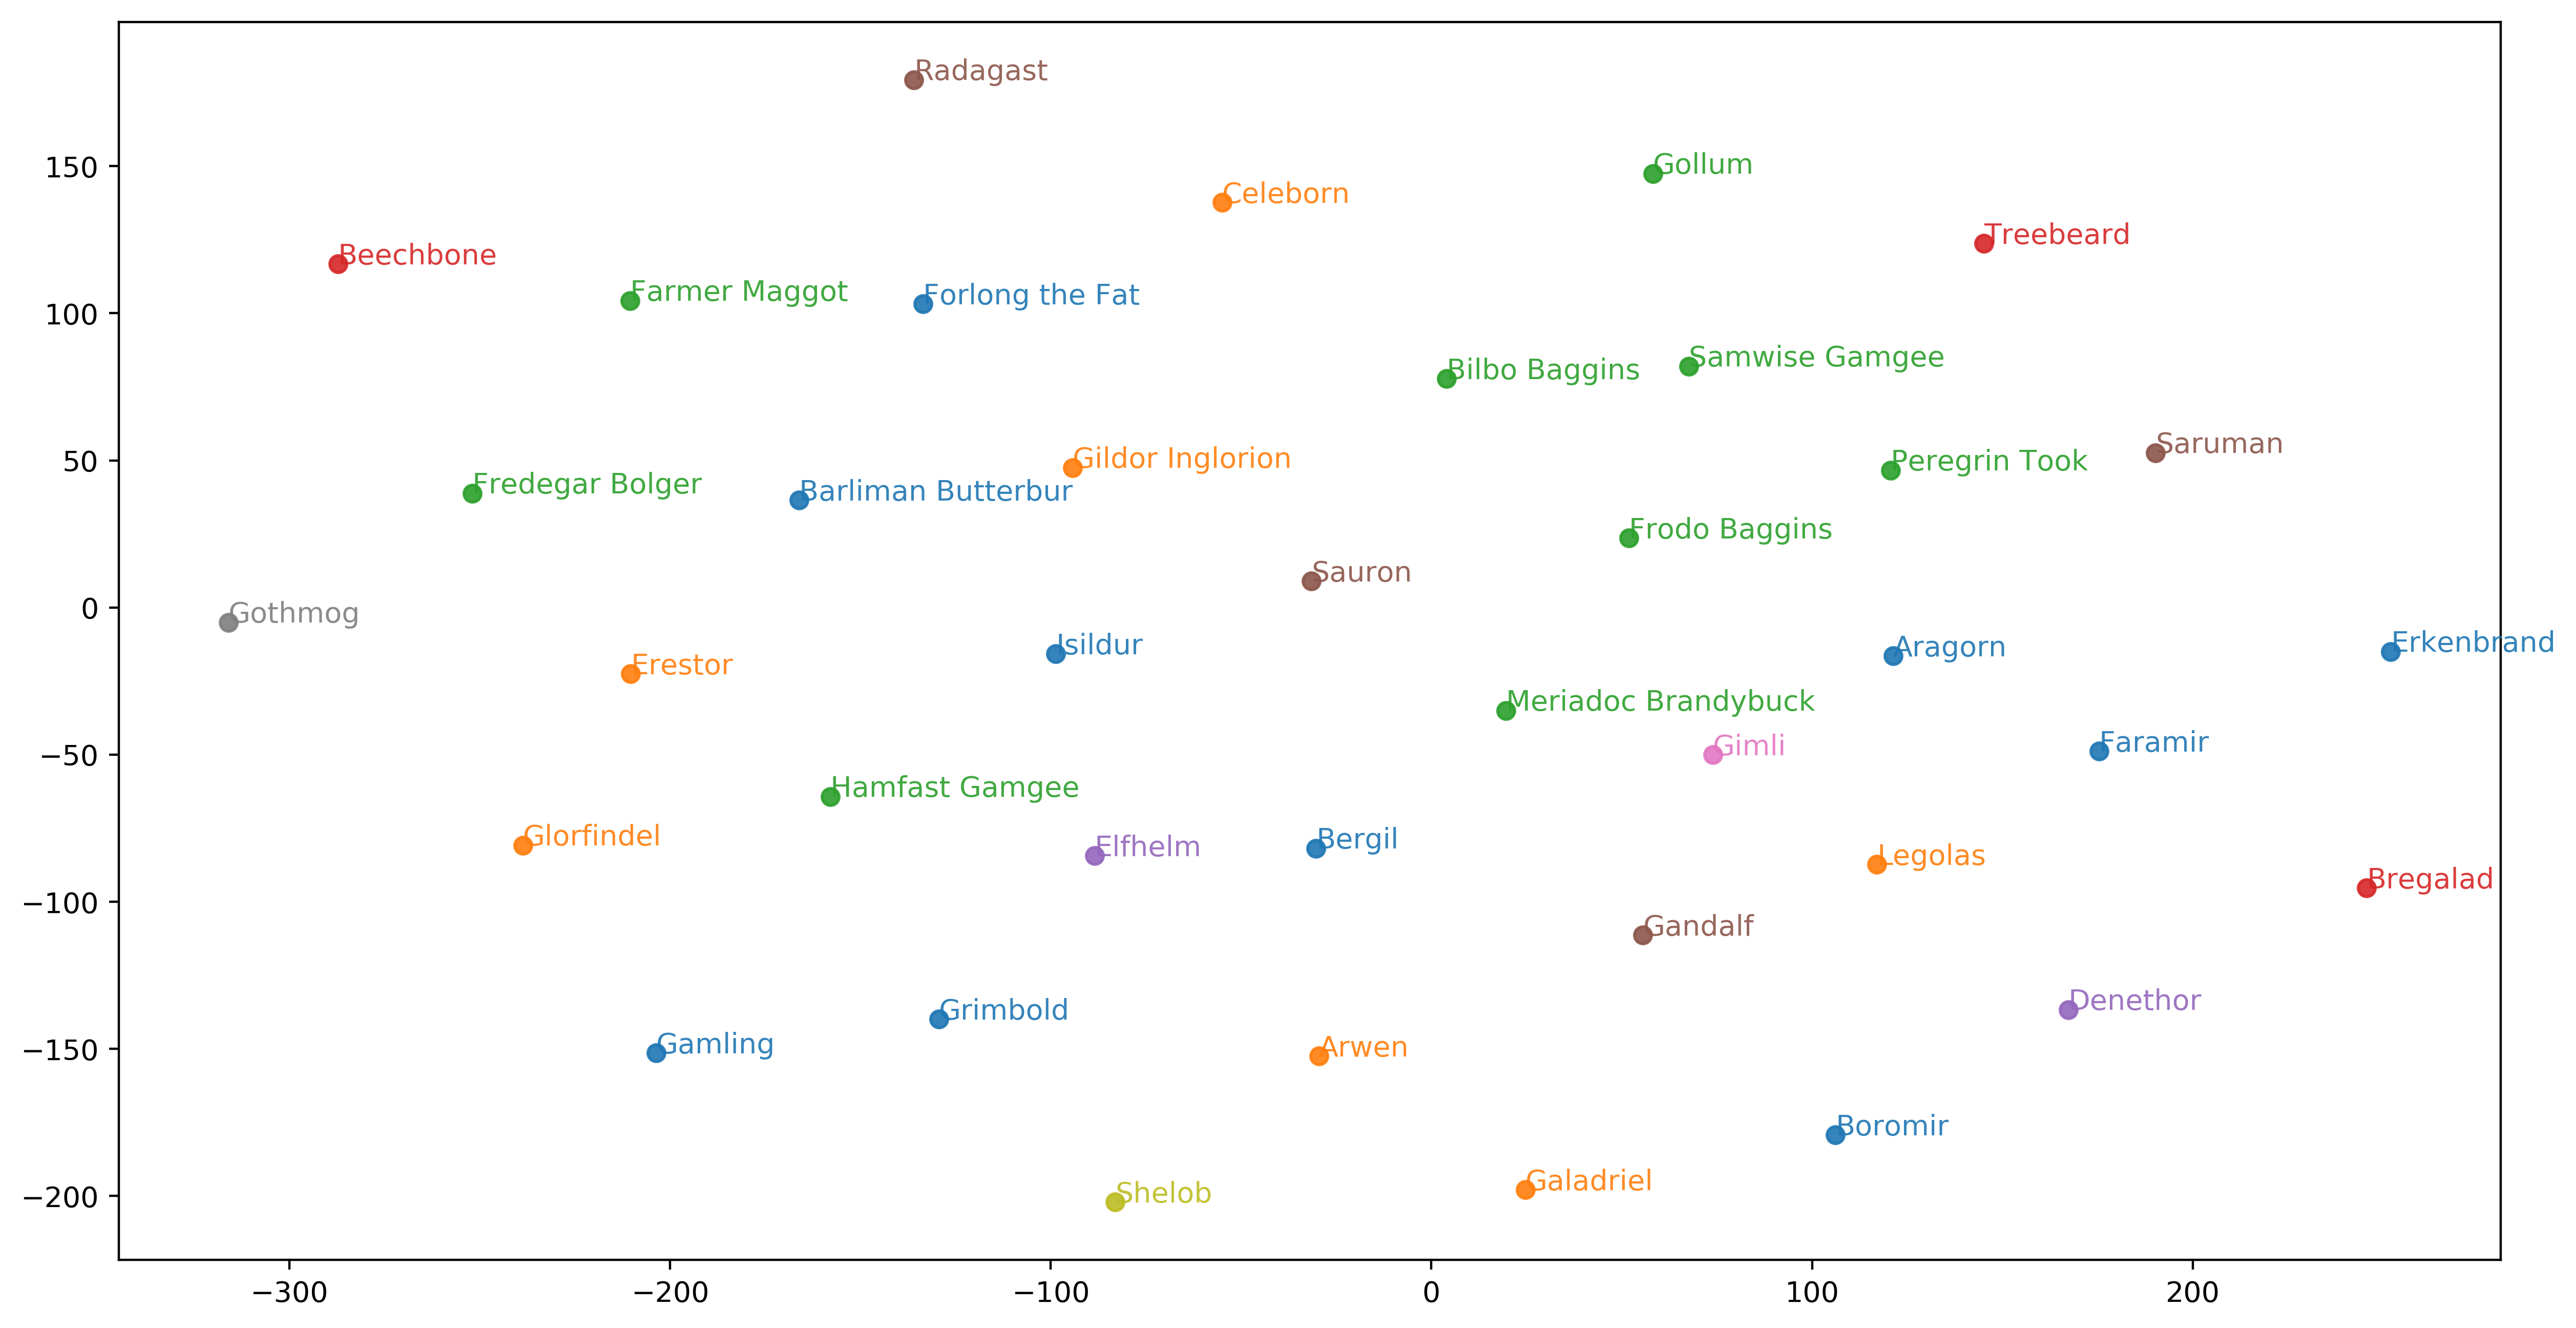

In [219]:
colors = {h:plt.cm.tab10.colors[i%10] for i,h in enumerate(characters["race"].unique())}
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(dfc)
dfc['x-tsne'] = tsne_results[:,0]
dfc['y-tsne'] = tsne_results[:,1]

fig = plt.figure(figsize=(15,8), dpi=400)
ax = fig.add_subplot(1,1,1)

dfc = pd.concat([dfc, characters], axis=1)
for i in range(len(dfc)):
    ax.scatter(
        x=dfc.iloc[i]["x-tsne"], 
        y=dfc.iloc[i]["y-tsne"],
        alpha=0.9,
        c=house_colors[dfc.iloc[i]["race"]]
    )
    ax.text(
        x=dfc.iloc[i]["x-tsne"],
        y=dfc.iloc[i]["y-tsne"],
        s=dfc.iloc[i]["full_name"],
        alpha=0.9,
        color=colors[dfc.iloc[i]["race"]]
    )
plt.show()

Персонажи с одинаковыми расами выделены на диаграмме одними цветами.

Можно увидеть, что всех хоббиты оказались в одной части диаграммы, рядом с ними находятся участники "Братства кольца".
Основные персонажи, которые часто контактируют друг с другом, сфокусированы в одной части рисунка, а персонажи, которые появляются в книгах не так часто, находятся дальше.

Даже если взять во внимание небольшую величину корпуса, на которых обучались GloVe-эмбеддинги, они неплохо показывают отношения между персонажами в книгах.

##  Интересные материалы по GloVe и word2vec, найденные в процессе работы.

  - [Недавнее выступление о методах для векторных представления на PyData](https://www.youtube.com/watch?v=6xPnEh_tJEc)
  - [Выступление по Gensim от разработчика Gensim на PyData](https://www.youtube.com/watch?v=tAxrlAVw-Tk)
  - [Статья из четырех частей с обзором разных методов для векторных представлений и работы с текстом](https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa)
  - [Сравнение GloVe и text2vec](http://dsnotes.com/post/glove-enwiki/)